In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!unzip -uq "/content/drive/My Drive/kaggle/KaKR 3 image classification/input/test.zip" -d "/content/drive/My Drive/kaggle/KaKR 3 image classification/input/test"


In [3]:
!unzip -u "/content/drive/My Drive/kaggle/KaKR 3 image classification/input/train.zip" -d "/content/drive/My Drive/kaggle/KaKR 3 image classification/input/train"


Archive:  /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train.zip
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00001.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00002.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00003.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00004.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00005.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00006.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00007.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00008.jpg  
  inflating: /content/drive/My Drive/kaggle/KaKR 3 image classification/input/train/train_00009.jpg

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

root_directory = '/content/drive/My Drive/kaggle/KaKR 3 image classification'

In [5]:
df_train = pd.read_csv(root_directory + '/input/train.csv')
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [0]:
# bbox x1 x2 y1 y2 is the bounding box that includes the car, let's see if the size are aligned

In [7]:
width = df_train.bbox_x2 - df_train.bbox_x1
height = df_train.bbox_y2 - df_train.bbox_y1

width = width.to_frame()
height = height.to_frame()

df_size = pd.concat([width, height], keys=['width', 'height'], axis=1)

df_size.head(5) # we can see that the bounding boxes are very different
# each image will have different number of pixels

,width,height
,0,0
0,640,381
1,236,183
2,192,118
3,244,144
4,771,506


# Preparing the data

In [8]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [9]:
# checking files and load them
DATA_PATH = root_directory + '/input/'
os.listdir(DATA_PATH)

['class.csv',
 'test.csv',
 'sample_submission.csv',
 'train.csv',
 'test.zip',
 'train.zip',
 '.keras',
 'test',
 'train']

In [0]:
# image folder directory
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [11]:
df_train.shape

(10016, 6)

In [12]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [13]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


# Data Exploration

In [14]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [15]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [0]:
# target variable (y) is 'class'. Thus our model will map each img file to a class number

In [17]:
len(set(os.listdir(TRAIN_IMG_PATH)))

10016

In [18]:
len(set(list(df_train.img_file)))

10016

In [19]:
# check if we aren't missing any training images
set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH))

True

In [20]:
# check if we aren't missing any test images
set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH))

True

In [21]:
print('number of training data', df_train.shape)
print('number of test data', df_test.shape)

number of training data (10016, 6)
number of test data (6169, 5)


In [0]:
#we have 10016 training images and we have 6169 testing images

In [23]:
df_class.shape

(196, 2)

In [24]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [0]:
# we have total of 192 different classes

# Class distribution

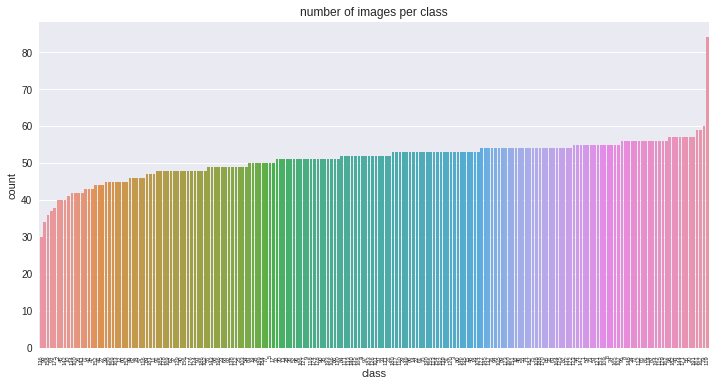

In [26]:
# let see how our training data is distributed in terms of the target variable.
# balanced distribution is very important for a classification problem.
plt.figure(figsize=(12,6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title('number of images per class')
plt.xticks(rotation=90, fontsize='xx-small')
plt.show()

In [27]:
countEachClass = df_train['class'].value_counts()
countEachClass.describe()

count    196.000000
mean      51.102041
std        5.350274
min       30.000000
25%       48.750000
50%       52.000000
75%       54.000000
max       84.000000
Name: class, dtype: float64

In [28]:
countEachClass.head()
# class 119 has 84 images, has the most images in that category

119    84
79     60
167    59
161    59
191    57
Name: class, dtype: int64

In [0]:
# generally the number doesn't seem too uneven

# Visualize the actual images

In [30]:
import PIL # python imaging library
from PIL import ImageDraw

tmp_imgs = df_train.img_file[100:110]
tmp_imgs.head()

100    train_00101.jpg
101    train_00102.jpg
102    train_00103.jpg
103    train_00104.jpg
104    train_00105.jpg
Name: img_file, dtype: object

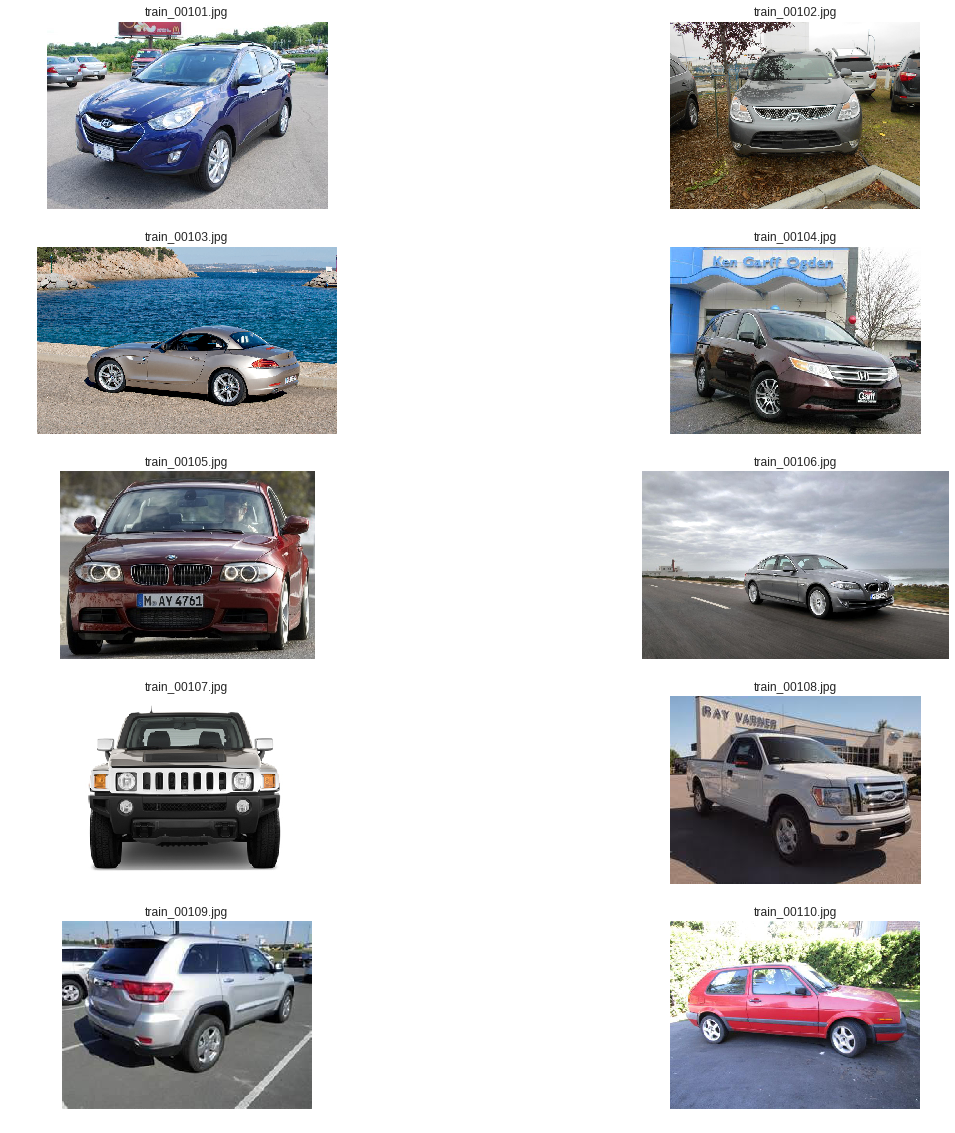

In [31]:
plt.figure(figsize=(20,20))

for index, file_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, file_name))
    plt.subplot(5,2, index+1)
    plt.title(file_name)
    plt.imshow(img)
    plt.axis('off')

# Drawing the bounding box

In [0]:
def draw_rect(context, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    context.line(points, fill=outline, width=width)

def generate_image_with_boundingbox(filename):
    if filename.split('_')[0] == 'train':
        IMG_PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        IMG_PATH = TEST_IMG_PATH
        data = df_test
    img = PIL.Image.open(os.path.join(IMG_PATH, filename))
    pos = data.loc[data["img_file"] == filename, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    return img

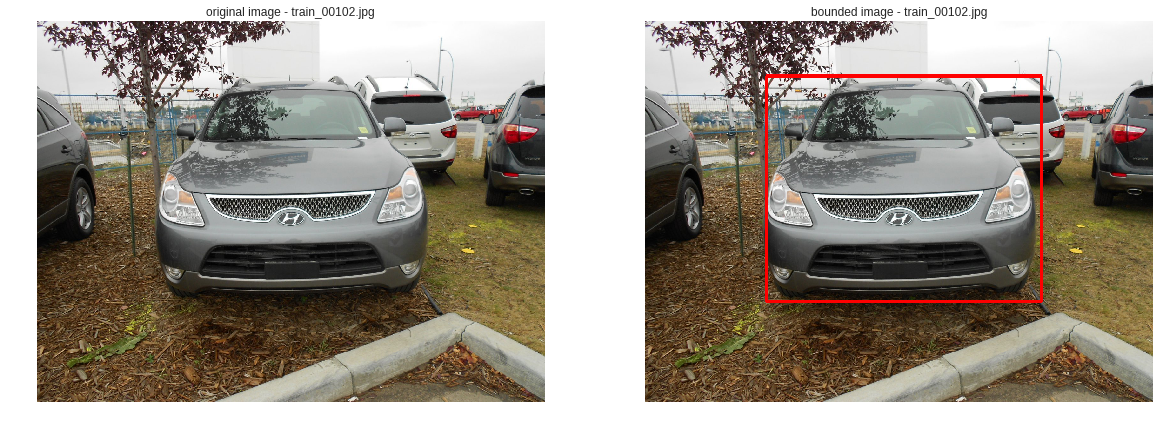

In [33]:
filename = "train_00102.jpg"

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
original_image = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, filename))
plt.title("original image - {}".format(filename))
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,2,2)
image_with_bbox = generate_image_with_boundingbox(filename)
plt.title("bounded image - {}".format(filename))
plt.imshow(image_with_bbox)
plt.axis('off')

plt.show()

## what if the data isn't provided with the bounding box?

As you can see, the left image contains extra information which isn't necessary (i.e. it includes noise). In this case, we need to manually label the bounding box or need to come up with a deep learning model that determines the bounding box.

# Modelling

In [0]:
# In this kernel, we will use the ResNet50 Pretrained Model.

'''
Spliting training data in train - validation sets.

Generally larger training set will result in a better model, but we need to
make sure the model isn't overfitted and it generalizes well. Thus we need to
leave some labeled data out so that we can check that the model isn't overfitted
to the training set.

We could just do the cross validation with the testing set by looking at the score
after submission, but daily limit for submission is about 5 times per day. Thus, it is
better to have a local validation set to check the model.
'''

## Splitting training set into train/validation sets

In [35]:
from sklearn.model_selection import train_test_split

df_train['class'] = df_train['class'].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

df_train.head() # removing the bounding box attributes from train data

,img_file,class
0,train_00001.jpg,108
1,train_00002.jpg,71
2,train_00003.jpg,76
3,train_00004.jpg,188
4,train_00005.jpg,44


In [0]:
index_list = np.arange(df_train.shape[0])

In [37]:
train_idx, val_idx = train_test_split(index_list, train_size=0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(8012, 2)
(2004, 2)
(6169, 1)


In [38]:
X_train.head()

,img_file,class
4766,train_04767.jpg,161
4851,train_04852.jpg,42
533,train_00534.jpg,37
132,train_00133.jpg,146
4885,train_04886.jpg,122


# Using Generator

In [0]:
# Generator is a must have in image processing, because general cloud environments and
# local development environments don't have enough memory to hold all image files.
# Thus in such circumstances, it is very beneficial to generate images by batch size
# to reduce memory usage.

# Instead of building our own generator, Keras provides a useful generator function called
# ImageDataGenerator. ImageDataGenerator from Keras would not work with non-img data, so
# it is a good practice to practice architecture a generator from scratch.

In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [41]:
# Parameter
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = False,
    zoom_range = 0.10,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train, 
    directory = DATA_PATH + 'train',
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory= DATA_PATH + 'train',
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = DATA_PATH + 'test',
    x_col = 'img_file',
    y_col = None,
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False
)

Found 8012 validated image filenames belonging to 196 classes.
Found 2004 validated image filenames belonging to 196 classes.
Found 6169 validated image filenames.


# Loading pretrained model - ResNet50

In [42]:
plt.figure(figsize=(7,7))

img = PIL.Image.open('./images/resnet50.jpg')
plt.title('resnet50 architecture')
plt.imshow(img)
plt.axis('off')

FileNotFoundError: ignored

<Figure size 504x504 with 0 Axes>

In [43]:
# path to manually downloaded ResNet50 weights file
resnet_weights_path = '/content/drive/My Drive/kaggle/KaKR 3 image classification/input/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(resnet_weights_path)

resNet_model = ResNet50(include_top=False, input_shape=(224,224,3), weights=resnet_weights_path)
# resNet_model.summary()


W0622 01:57:07.915843 139754403035008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



/content/drive/My Drive/kaggle/KaKR 3 image classification/input/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


W0622 01:57:07.984757 139754403035008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 01:57:08.006084 139754403035008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0622 01:57:08.047425 139754403035008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0622 01:57:08.048678 139754403035008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0622 01:57:11.328860 1397544030

In [44]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(resNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


Becareful when using Pretrained Model, because they might exclude the Model output since
they are used widely for different situations. In such cases (just like this case) we should
make our own output layer. We need 196 classes as our last layer.

There are 2 ways of making a model. 1) using Sequential() 2) using Model

# Model Compile

In [45]:
'''
Since we've just made the model, we need to decide how it will learn.
We need to decide the learning method, learning rate, what measuring fator, etc.
We can come up with our own functions but in general case we can use the provided ones.
'''

"\nSince we've just made the model, we need to decide how it will learn.\nWe need to decide the learning method, learning rate, what measuring fator, etc.\nWe can come up with our own functions but in general case we can use the provided ones.\n"

In [46]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

W0622 01:57:42.764312 139754403035008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Model Training

In [0]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [0]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_resnet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [es, ckpt]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

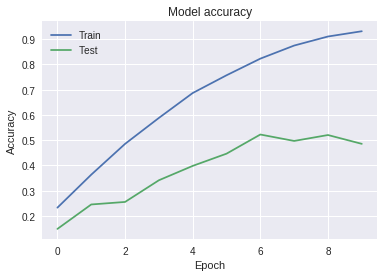

In [51]:
# Training History Visualization
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

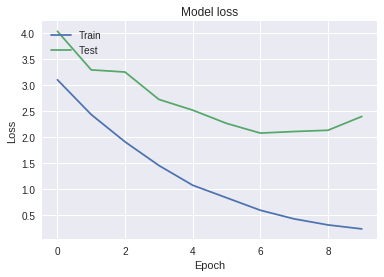

In [52]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [53]:
# Model Predict

%%time
test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

193/193 [==============================] - 73s 376ms/step
CPU times: user 1min 13s, sys: 12.4 s, total: 1min 25s
Wall time: 1min 12s


In [54]:
prediction

array([[2.61541642e-02, 2.89764783e-15, 7.60583491e-13, ...,
        1.16060252e-10, 2.98287589e-10, 1.16030197e-09],
       [1.05602140e-08, 7.78643923e-08, 6.50181553e-09, ...,
        3.30214498e-05, 9.72238719e-01, 1.14994164e-05],
       [1.47571679e-15, 6.80453076e-14, 2.40585987e-08, ...,
        3.57862177e-11, 7.58441435e-11, 6.05753208e-12],
       ...,
       [1.01602659e-19, 1.00893415e-14, 6.44177112e-09, ...,
        8.49884019e-13, 3.91232913e-09, 3.32087629e-13],
       [1.01709863e-17, 3.24926967e-17, 3.24312743e-04, ...,
        2.24496704e-13, 7.26697522e-11, 2.43258157e-11],
       [6.97391306e-06, 5.70827160e-06, 1.22678676e-03, ...,
        2.80420081e-05, 2.34956242e-05, 5.07411838e-04]], dtype=float32)

In [55]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,img_file,class
0,test_00001.jpg,125
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,148
4,test_00005.jpg,18
